Расчет retention и rolling retention
---

В первую очередь загрузим необходимнные данные и посмотрим на них

In [1]:
import pandas as pd
df = pd.read_csv('test(1).csv', delimiter  = ',', parse_dates=['Date'])
df.head(5)

,PlayerId,Event,Date
0,b91eedaf-ba56-4b80-9c23-cd5d48595579,Install,2020-05-03
1,b91eedaf-ba56-4b80-9c23-cd5d48595579,Session Start,2020-05-03
2,b91eedaf-ba56-4b80-9c23-cd5d48595579,Session Start,2020-05-04
3,b91eedaf-ba56-4b80-9c23-cd5d48595579,Session Start,2020-05-05
4,b91eedaf-ba56-4b80-9c23-cd5d48595579,Session Start,2020-05-06


In [2]:
df.describe(include='all')

,PlayerId,Event,Date
count,66,66,66
unique,13,2,13
top,f0fec61f-4eba-441e-bfb9-574d449cac7b,Session Start,2020-05-03 00:00:00
freq,10,53,23
first,NaN,NaN,2020-04-30 00:00:00
last,NaN,NaN,2020-05-12 00:00:00


Можно сделать вывод, что у нас имеется 13 различных пользователей и два главных события - установка и сессия.

Для последующих расчетов кол-ва дней в игре игрока я сделала отдельную колонку 'InstallDate'

In [3]:
install_df = df.loc[df['Event'] == 'Install']
df['InstallDate'] = None
for index, row  in install_df.iterrows():
    df.loc[df['PlayerId']==row['PlayerId'], 'InstallDate'] = row['Date']
df['InstallDate'] = pd.to_datetime(df['InstallDate'],format="%Y-%m-%d") 

In [4]:
import datetime as dt
df['Seniority'] = (df['Date'] - df['InstallDate']).dt.days 

# df.loc[df['Seniority'] < 0, 'Date'] = dt.datetime.strptime('2020-05-30', "%Y-%m-%d")

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

Сгруппируем данные по дате установки и кол-ву дней в игре.


Для каждой кагорты подсчитаем сколько людей было активно в различные дни. 

In [13]:
group = df.groupby(['InstallDate', 'Seniority'])
cohort_data = group['PlayerId'].nunique()
cohort_data = cohort_data.reset_index()
cohort_data

,InstallDate,Seniority,PlayerId
0,2020-05-01,0,1
1,2020-05-01,1,1
2,2020-05-01,4,1
3,2020-05-02,0,1
4,2020-05-02,1,1
5,2020-05-03,-3,1
6,2020-05-03,0,9
7,2020-05-03,1,7
8,2020-05-03,2,4
9,2020-05-03,3,3


Можно заметить странные -3 в колонке Seniority. 

Это ошибка в данных, вышло так что для какого-то пользователя дата установки позже чем дата сессии. 

In [14]:
cohort_counts = cohort_data.pivot(index='InstallDate', columns='Seniority', values='PlayerId')
# Начальное кол-во игроков для каждой кагорты
base = cohort_counts[0]

# Считаем процент активнойсти. 
# Кол-во игроков в N День / Кол-во игроков в 0 день
retention = cohort_counts.divide(base, axis=0).round(3)
retention

Seniority,-3,0,1,2,3,4,6,7,8,9
InstallDate,,,,,,,,,,
2020-05-01,NaN,1.0,1.000,NaN,NaN,1.000,NaN,NaN,NaN,NaN
2020-05-02,NaN,1.0,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-03,0.111,1.0,0.778,0.444,0.333,0.111,0.111,0.222,0.222,0.222
2020-05-05,NaN,1.0,1.000,NaN,0.500,NaN,NaN,NaN,NaN,NaN


Выводы уже можно сдеать по сводной таблице. Но мы за наглядность, поэтому сделаем heatmap

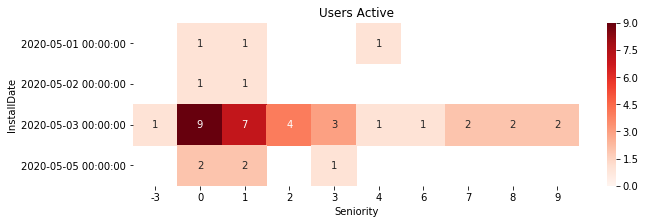

In [8]:
plt.figure(figsize=(10,3))
plt.title('Users Active')
ax = sns.heatmap(data=cohort_counts, annot=True, vmin=0.0,cmap='Reds')
ax.set_yticklabels(cohort_counts.index)
fig=ax.get_figure()
fig.savefig("Retention Counts.png")

plt.show()

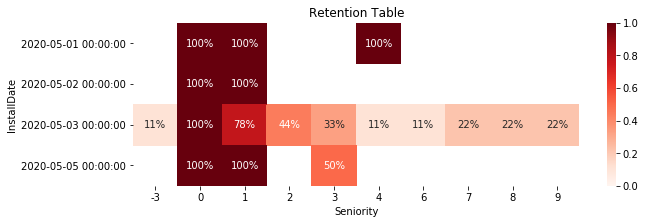

In [9]:
plt.figure(figsize=(10,3))
plt.title('Retention Table')
ax = sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=1,cmap='Reds')
ax.set_yticklabels(retention.index)
fig=ax.get_figure()
fig.savefig("Retention_Rate.png")

plt.show()

Выводы Retention
---
Для игроков, которые пришли 2020-05-03:
 - Day 1 retention = 78%
 - Day 7 retention = 11%
 - Day 14 retention = ?
 
      
     
---     
Нужно узнать Rolling retention.
Если Day N Retention показывает, какой процент новых пользователей вернулись в продукт в конкретный день с момента прихода, то Rolling Retention показывает, какой процент новых пользователей вернулись в продукт в конкретный день с момента прихода или **любой день после него.** 

То есть формула для Rolling retention это Кол-во игроков на N день и позже / Кол-во игроков в 0 день

In [10]:
rolling_retention = cohort_counts# .cumsum(axis = 1)
rolling_retention = rolling_retention[rolling_retention.columns[::-1]]

rolling_retention = rolling_retention.cumsum(axis = 1)
base = rolling_retention[0]
rolling_retention = rolling_retention.divide(base, axis=0).round(3)
rolling_retention = rolling_retention[rolling_retention.columns[::-1]]
rolling_retention

Seniority,-3,0,1,2,3,4,6,7,8,9
InstallDate,,,,,,,,,,
2020-05-01,NaN,1.0,0.667,NaN,NaN,0.333,NaN,NaN,NaN,NaN
2020-05-02,NaN,1.0,0.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-03,1.032,1.0,0.710,0.484,0.355,0.258,0.226,0.194,0.129,0.065
2020-05-05,NaN,1.0,0.600,NaN,0.200,NaN,NaN,NaN,NaN,NaN


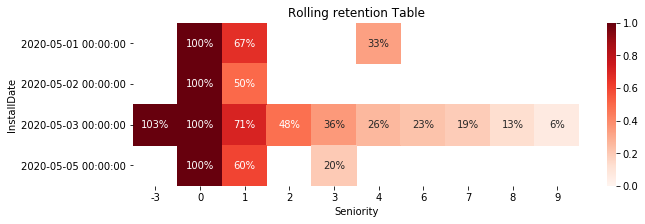

In [17]:
plt.figure(figsize=(10,3))
plt.title('Rolling retention Table')
ax = sns.heatmap(data=rolling_retention, annot=True, fmt='.0%', vmin=0.0, vmax=1,cmap='Reds')
ax.set_yticklabels(rolling_retention.index)
fig=ax.get_figure()
fig.savefig("RollingRetention_Rate.png")

plt.show()

Выводы по rolling retention 
--
Для игроков, которые пришли 2020-05-03 
Day 3 rolling retention = 36%

Общие выводы + бонус
---

**Retention** и **rolling retention** это качетсвенный показатель, который показывает **% удержания аудиториии**. 

Этот показатель крайней важен для планирования ресурсов всего проэкта, так как на его основе можно подсчитать LTV и множество других метрих. Чем выше retention тем лучше для проекта.

----
Бонус это красивый график сравнения двух видов retention для кагорты 2020-05-03

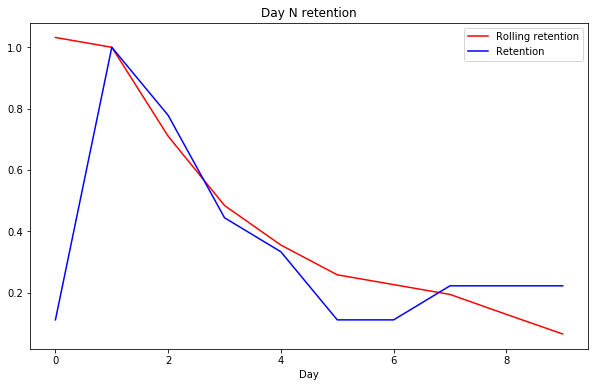

In [12]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)

ax1.set_title("Day N retention")    
ax1.set_xlabel('Day')

ax1.plot(rolling_retention.values[2], c='r', label='Rolling retention')
ax1.plot(retention.values[2], c='b', label='Retention')
leg = ax1.legend()

plt.show()